In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'

import time
from multiprocessing import Pool
from tqdm.auto import tqdm
import re

import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt

import noctiluca as nl
import bayesmsd

In [2]:
import matplotlib as mpl
import matplotlib.colors as mplc

mpl.rcParams['figure.dpi'] = 300

mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['font.family'] = "sans-serif"
mpl.rcParams['font.sans-serif'] = "DejaVu Sans"
mpl.rcParams['font.size'] = 6

mpl.rcParams['xtick.major.size'] = 2
mpl.rcParams['xtick.major.pad'] = 1
mpl.rcParams['ytick.major.size'] = 2
mpl.rcParams['ytick.major.pad'] = 1
mpl.rcParams['xtick.minor.size'] = 1
mpl.rcParams['xtick.minor.pad'] = 0.5
mpl.rcParams['ytick.minor.size'] = 1
mpl.rcParams['ytick.minor.pad'] = 0.5
mpl.rcParams['axes.labelpad'] = 1
mpl.rcParams['axes.titlepad'] = 3
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['legend.handletextpad'] = 0.4
mpl.rcParams['legend.columnspacing'] = 1.0
mpl.rcParams['legend.frameon'] = False

mpl.rcParams['figure.subplot.top'] = 0.75
mpl.rcParams['figure.subplot.bottom'] = 0.25
mpl.rcParams['figure.subplot.left'] = 0.25
mpl.rcParams['figure.subplot.right'] = 0.75

In [3]:
filename = 'data/20250411_chromatin_dynamics_all_data.h5'
data = nl.io.load.hdf5(filename, '/data')

In [4]:
colors = {
    'blue'    : '#0077BB',
    'cyan'    : '#33BBEE',
    'teal'    : '#009988',
    'orange'  : '#EE7733',
    'red'     : '#CC3311',
    'magenta' : '#EE3377',
    'grey'    : '#BBBBBB',
}

# Plots

In [7]:
def msd_for_plotting(dt, tau_e, params, fitname, d=2):
    dummy_fit = bayesmsd.lib.NPFit([np.array([d*[0.]])],
                                   motion_blur_f=tau_e,
                                   parametrization='(log(αΓ), α)')
    for paramname in dummy_fit.parameters:
        if 'log(σ²)' in paramname and '(dim 0)' not in paramname and paramname not in params:
            dummy_fit.parameters[paramname].fix_to = 'log(σ²) (dim 0)'
    params = dummy_fit.fill_dependent_params(params)
    
    msd = dummy_fit.MSD(params, dt)
    if 'minflux' not in fitname:
        return 0.5*msd
    else:
        return msd

def get_params_from_joint_mci(mci, fitname):
    out = {key+' (dim 0)' : m for key, (m, ci) in mci.items() if key in {'α', 'log(αΓ)'}}
    if 'minflux' not in fitname:
        out['log(αΓ) (dim 0)'] += np.log(2) # 2-loc
        
    for key, (m, ci) in mci.items():
        if key.startswith(fitname):
            out[key[(len(fitname)+1):]] = m

    return out

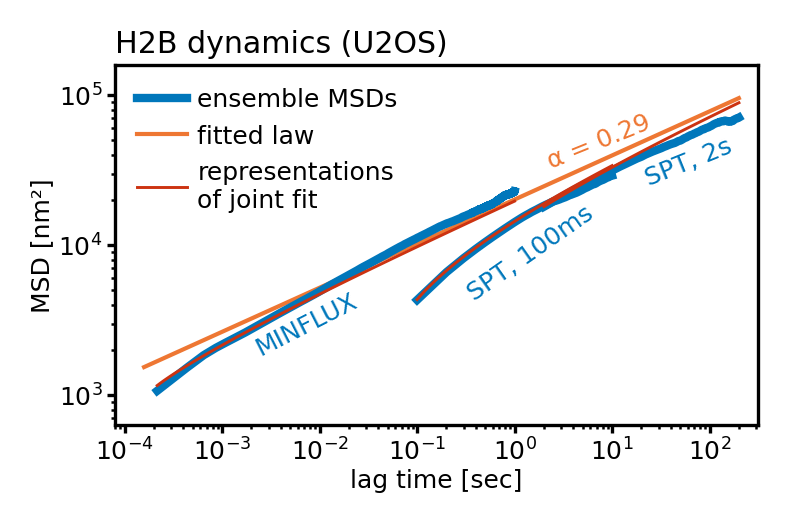

In [9]:
ct = 'U2OS' # set 'U2OS' or 'mESC'
treatment = 'ctrl'
cond = f'H2B, {ct}, {treatment}'

kw_data = dict(color=colors['blue'], linewidth=2)
kw_fits = dict(color=colors['red'], linewidth=0.7, zorder=10)
kw_law  = dict(color=colors['orange'], linewidth=1, zorder=0)

fig = plt.figure(figsize=[6.6*0.65, 2.4])

## fit result (base line)
mci = nl.io.load.hdf5(f'data/20250327_mci_NPFit-aGparam_{ct}.h5')[treatment]['minflux + SPT']

xplot = np.logspace(-3.8, 2.3, 100)
params = get_params_from_joint_mci(mci, 'minflux')
for key in params:
    if 'log(σ²)' in key:
        params[key] = -np.inf

msd = msd_for_plotting(xplot, 0, params, 'minflux (dummy)') * 1e6
plt.plot(xplot, msd, **kw_law)

## minflux

data.makeSelection(cond)
data.refineSelection('minflux')
msd = nl.analysis.MSD(data)*1e18 # nm²

dt = data[0].meta['Δt']
t = dt*np.arange(1, len(msd))
ind = t <= 1

plt.plot(t[ind], msd[1:][ind], **kw_data)

xplot = np.logspace(np.log10(dt), 0, 100)
params = get_params_from_joint_mci(mci, 'minflux')
msd = msd_for_plotting(xplot, 0.9999*dt, params, 'minflux') * 1e6
plt.plot(xplot, msd, **kw_fits)

## SPT

framerates = {'100ms' : (0.1, 0.08671), '2s' : (2, 0.08671)}
for dt_tag in framerates:
    dt, tau_e = framerates[dt_tag]

    data.makeSelection([cond, 'SPT', dt_tag], logic=all)
    msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc

    dt = data[0].meta['Δt']
    t = np.arange(1, len(msd))
    ind = t <= 100
    t = t * dt

    plt.plot(t[ind], msd[1:][ind], **kw_data)

    xplot = np.logspace(np.log10(dt), np.log10(100*dt), 100)
    params = get_params_from_joint_mci(mci, f'SPT-{dt_tag}')
    msd = msd_for_plotting(xplot, tau_e, params, 'SPT') * 1e6
    plt.plot(xplot, msd, **kw_fits)
        
## Formatting

plt.plot(0, 0, **kw_data, label='ensemble MSDs')
plt.plot(0, 0, **kw_law,  label='fitted law')
plt.plot(0, 0, **kw_fits, label='representations\nof joint fit')
plt.legend(loc='upper left')

if ct == 'U2OS':
    plt.text(2, 3e4, f"α = {params['α (dim 0)']:.2f}",
             color=kw_law['color'],
             ha='left', va='bottom', rotation=22,
            )
    plt.text(2e-3, 1.7e3, 'MINFLUX',
             color=kw_data['color'],
             ha='left', va='bottom', rotation=27,
            )
    plt.text(3e-1, 4e3, 'SPT, 100ms',
             color=kw_data['color'],
             ha='left', va='bottom', rotation=35,
            )
    plt.text(2e1, 2.3e4, 'SPT, 2s',
             color=kw_data['color'],
             ha='left', va='bottom', rotation=22,
            )
elif ct == 'mESC':
    plt.text(5e-3, 8e2, f"α = {params['α (dim 0)']:.2f}",
             color=kw_law['color'],
             ha='left', va='bottom', rotation=28,
            )
    plt.text(1e-3, 2.2e3, 'MINFLUX',
             color=kw_data['color'],
             ha='left', va='bottom', rotation=15,
            )
    plt.text(3e-1, 3.3e3, 'SPT, 100ms',
             color=kw_data['color'],
             ha='left', va='bottom', rotation=28,
            )
    plt.text(1.5e1, 4e4, 'SPT, 2s',
             color=kw_data['color'],
             ha='left', va='bottom', rotation=35,
            )

plt.title(f'H2B dynamics ({ct})')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [nm²]')
plt.ylim([10**(2.8), 10**(5.2)])
plt.xlim([10**(-4.1), 10**(2.5)])

# plt.savefig(f'{ct}.pdf')
plt.show()

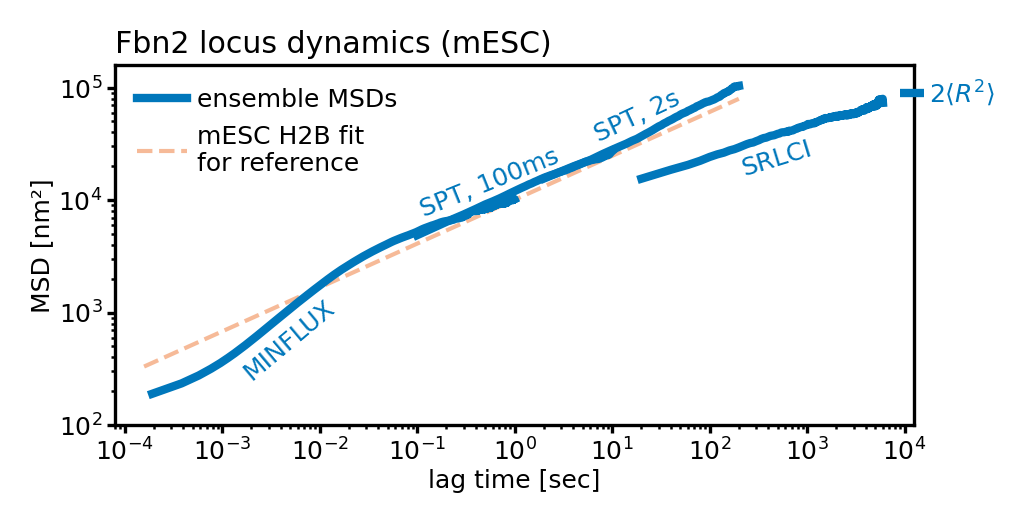

In [11]:
tags = ['array', 'C36']

kw_data = dict(color=colors['blue'], linewidth=2, zorder=10)
kw_fits = dict(color=colors['red'], linewidth=0.7, zorder=10)
kw_law  = dict(color=colors['orange'], linewidth=1, zorder=0, linestyle='--', alpha=0.5)

fig = plt.figure(figsize=[8.2*0.65, 2.4])

## ref from H2B fit
mci = nl.io.load.hdf5(f'data/20250327_mci_NPFit-aGparam_mESC.h5')['ctrl']['minflux + SPT']

xplot = np.logspace(-3.8, 2.3, 100)
params = get_params_from_joint_mci(mci, 'minflux')
for key in params:
    if 'log(σ²)' in key:
        params[key] = -np.inf

msd = msd_for_plotting(xplot, 0, params, 'minflux (dummy)') * 1e6
plt.plot(xplot, msd, **kw_law)

## minflux

data.makeSelection(tags, logic=all)
data.refineSelection('minflux')
msd = nl.analysis.MSD(data)*1e18 # nm²

dt = data[0].meta['Δt']
t = dt*np.arange(1, len(msd))
ind = t <= 1

plt.plot(t[ind], msd[1:][ind], **kw_data)

## SPT

framerates = {'100ms' : (0.1, 0.08671), '2s' : (2, 0.08671)}
for dt_tag in framerates:
    dt, tau_e = framerates[dt_tag]

    data.makeSelection(tags+['SPT', dt_tag], logic=all)
    msd = nl.analysis.MSD(data)/2*1e6 # nm², 2-loc --> 1-loc

    dt = data[0].meta['Δt']
    t = np.arange(1, len(msd))
    ind = t <= 100
    t = t * dt

    plt.plot(t[ind], msd[1:][ind], **kw_data)

## SRLCI

data.makeSelection(tags, logic=all)
data.refineSelection('SRLCI')
data_msd = data.apply(lambda traj: traj.dims([0, 1], keepmeta=['Δt']))
msd = nl.analysis.MSD(data_msd)/2*1e6 # nm², 2-loc --> 1-loc
J = np.nanmean(np.concatenate([traj.abs()[:][:, 0] for traj in data_msd])**2)/2*1e6

dt = data[0].meta['Δt']
t = np.arange(1, len(msd))
ind = t <= 300
t = t * dt

plt.plot(t[ind], msd[1:][ind], **kw_data)
plt.hlines(2*J, 9e3, 10**(4.2), **kw_data, clip_on=False)
        
## Formatting

plt.plot(0, 0, **kw_data, label='ensemble MSDs')
plt.plot(0, 0, **kw_law,  label='mESC H2B fit\nfor reference')
plt.legend(loc='upper left')

plt.text(1.5e-3, 2.3e2, 'MINFLUX',
         color=kw_data['color'],
         ha='left', va='bottom', rotation=40,
        )
plt.text(1e-1, 6.5e3, 'SPT, 100ms',
         color=kw_data['color'],
         ha='left', va='bottom', rotation=22,
        )
plt.text(6, 3e4, 'SPT, 2s',
         color=kw_data['color'],
         ha='left', va='bottom', rotation=25,
        )
plt.text(2e2, 1.5e4, 'SRLCI',
         color=kw_data['color'],
         ha='left', va='bottom', rotation=17,
        )
plt.text(10**(4.25), 2*J, r'$2\langle R^2\rangle$',
         color=kw_data['color'],
         ha='left', va='center',
        )

plt.title('Fbn2 locus dynamics (mESC)')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('lag time [sec]')
plt.ylabel('MSD [nm²]')
plt.xticks(np.logspace(-4, 5, 10))
plt.gca().set_xticks([i*10**j for j in range(-5, 6) for i in range(2, 10)], minor=True)
plt.ylim([10**(2), 10**(5.2)])
plt.xlim([10**(-4.1), 10**(4.1)])

# plt.savefig(f'array.pdf')
plt.show()